## Dell Pre-Processing and Modeling

In [ ]:
import statsmodels.api as sm
import pandas as pd
import re,string
import nltk
import ssl
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from patsy import dmatrices
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet as wn
from nltk.stem import 	WordNetLemmatizer
import matplotlib.pyplot as plt
import warnings
%pylab inline
import numpy as np
from sklearn.manifold import MDS
from sklearn.metrics import euclidean_distances
import spacy
from sklearn.feature_extraction.text import CountVectorizer
from nltk.collocations import BigramAssocMeasures
from nltk.collocations import BigramCollocationFinder
from nltk.tokenize import word_tokenize
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_samples, silhouette_score


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
Populating the interactive namespace from numpy and matplotlib


## Dell Pre-Processing

In [ ]:
##SAVE DATA FILES IN GOOGLE DRIVE (IN MYDRIVE FOLDER)
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/
%cd Capstone_Data_part1/

Mounted at /content/drive


In [ ]:
#Read ctq dataset with seperated sentences based on agent and chat
ctq_sample = pd.read_csv("ctq_with_sentences.csv")


In [ ]:
ctq_sample = ctq_sample.drop_duplicates("Case_number")

In [ ]:
labeled = pd.read_csv('Manual.csv')

### Given lack of high computational resources, used 100000 sample chats to perform analysis

In [ ]:
labeled = labeled[['Case_number', 'manual_score']]
inner_join_df= pd.merge(ctq_sample, labeled, on='Case_number', how='inner')
training_data = inner_join_df.drop_duplicates('Case_number')
ctq_sample = ctq_sample[~ctq_sample['length_of_chat'].isna()] 
ctq_sample = ctq_sample.sample(100000, random_state = 42)

In [ ]:
ctq_sample.columns

Index(['Unnamed: 0', 'FISC_QTR_VAL', 'FISC_WEEK_VAL', 'Group_name',
       'Region_name', 'Sub_Region_name', 'Case_number', 'Chat_Create_date',
       'Chat_Txnsrpt_body', 'Chat_parsed', 'length_of_chat', 'time_of_chat',
       'hour_of_chat', 'Agent Sentences', 'Customer Sentences',
       'Combined Sentences'],
      dtype='object')

In [ ]:
#In addition to common stopwords, add additional common words found in tech support jargon
ignored_words = list(stopwords.words('english'))
ignored_words.extend('''thank please name phone 39 yes moment email contacting give get need may let reach
                        confirm number chat disconnected hello today could still good know minutes xx hi okay
                        send apologize best work inconvenience thanks already well along concern check
                        follow would use also ok one sure like contact xxxx see ask asking questions steps great
                        fine amp together right back ways done chatting receive go us else case correct time
                        service help allow day understand confirmation anything support assist information tag
                        servicetag customer survey feedback agent servicetage feel free days business mins next
                        cte resolution servicetagized issue issues respond chats 7490 wait i\\x1all i\\x1am
                        quick move user details review prosupport address quot'''.split())

### Cleaning Pipeline

 * Convert list of sentences into string
 * Lowercase words
 * Remove [+XYZ chars] in content
 * Remove multiple spaces in content
 * Remove ellipsis (and last word)
 * Replace dash between words
 * Remove punctuation
 * Remove stopwords
 * Keep tokens greater than length 1
 * Lemmatize word

In [ ]:
wordnet_lemmatizer = WordNetLemmatizer()
def containsNumber(value):
  if True in [char.isdigit() for char in value]:
      return True
  return False

def clean_tokenize(text):
  text = re.sub(r'[^\w\s]', '',text.lower())
  text = str(text).lower()  # Lowercase words
  text = re.sub(r"\[(.*?)\]", "", text)  # Remove [+XYZ chars] in content
  text = re.sub(r"\s+", " ", text)  # Remove multiple spaces in content
  text = re.sub(r"\w+…|…", "", text)  # Remove ellipsis (and last word)
  text = re.sub(r"(?<=\w)-(?=\w)", " ", text)  # Replace dash between words
  text = re.sub(
      f"[{re.escape(string.punctuation)}]", "", text
  )  
  punc = string.punctuation
  words = []
  for word in word_tokenize(text):
    if word not in ignored_words and not word.isdigit() and '_' not in word and len(word) > 1 and (not containsNumber(word)):
      words.append(wordnet_lemmatizer.lemmatize(word))
  
  return words

def tokenize_sentences(df, col):
  tmp = pd.DataFrame(df[col], index= df.index)
  tmp[col] = tmp[col].apply(lambda x: x[1:-1].split(','))
  tmp['String Sentences'] = tmp[col].apply(lambda x: ''.join(x))
  tmp = pd.DataFrame(tmp['String Sentences'], index= df.index)

  tmp['tokens'] = tmp['String Sentences'].map(clean_tokenize)
  return tmp




### Tokenize Agents, Customers and Combined Sentences

In this analysis, we used the whole sentence in our modeling since that gave us the best results

**Possible the customers sentences on their own could provide better results based on deanonmyized data**

In [ ]:
# agent_sentences = tokenize_sentences(ctq_sample, 'Agent Sentences')
# customer_sentences = tokenize_sentences(ctq_sample, 'Customer Sentences')
combined_sentences = tokenize_sentences(ctq_sample, 'Combined Sentences')

In [ ]:
# agent_raw_sentences = list(agent_sentences['String Sentences'].values)
# customer_raw_sentences = list(customer_sentences['String Sentences'].values)
combined_raw_sentences = list(combined_sentences['String Sentences'].values)

In [ ]:
# agent_sentences = list(agent_sentences.tokens.values)
# customer_sentences = list(customer_sentences.tokens.values)
combined_sentences = list(combined_sentences.tokens.values)

## Modeling

### Generate Word Embeddings and Document Embeddings

In [ ]:
# RUN ONLY ONCE UNLESS WANT TO RETRAIN
from gensim.models import Word2Vec

#Generate word embeddings using Word2Vec with dimensionality 300 (hyperparameter)
# model_agent = Word2Vec(agent_sentences, min_count=5, workers = 8, size=100, seed = 42)
# model_customer = Word2Vec(customer_sentences, min_count=5, workers = 8, size=100, seed = 42)
model_combined = Word2Vec(combined_sentences, min_count=10, workers = 8, size=300, seed = 42)
# # summarize the loaded model
# print(model_agent)
# # summarize vocabulary
# words = list(model_agent.wv.vocab)
# print(words)
# # access vector for one word
# print(model_agent['sentence'])
# model_agent.save('agent_model.bin')
# model_customer.save('customer_model.bin')
model_combined.save('combined_model.bin')

In [ ]:
# RUN ONLY ONCE UNLESS WANT TO RETRAIN
from gensim.models.doc2vec import Doc2Vec, TaggedDocument


# documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(customer_raw_sentences)]
# documents2 = [TaggedDocument(doc, [i]) for i, doc in enumerate(agent_raw_sentences)]
documents3 = [TaggedDocument(doc, [i]) for i, doc in enumerate(combined_raw_sentences)]

# model_doc_customers = Doc2Vec(documents, vector_size=100, min_count=1, workers=8, seed = 42, dm = 1)
# model_doc_agents = Doc2Vec(documents2, vector_size=100, min_count=1, workers=8, seed = 42, dm = 1)
model_doc_combined = Doc2Vec(documents3, vector_size=300, min_count=1, workers=8, seed = 42, dm = 1)


# model_doc_agents.save('doc_agent_model.bin')
# model_doc_customers.save('doc_customer_model.bin')
model_doc_combined.save('doc_combined_model.bin')

In [ ]:
from gensim.models import Word2Vec

model_agent = Word2Vec.load('agent_model.bin')
model_customer = Word2Vec.load('customer_model.bin')
model_combined = Word2Vec.load('combined_model.bin')

In [ ]:
#
from gensim.models.doc2vec import Doc2Vec

# model_doc_agents = Doc2Vec.load('doc_agent_model.bin')
# model_doc_customers = Doc2Vec.load('doc_customer_model.bin')
model_doc_combined = Doc2Vec.load('doc_combined_model.bin')

In [ ]:
vectors_agent = model_agent.wv.vectors
words_agent = model_agent.wv.index2word

vectors_customer = model_customer.wv.vectors
words_customer = model_customer.wv.index2word

vectors_combined = model_combined.wv.vectors
words_combined = model_combined.wv.index2word

In [ ]:
model_combined.wv.most_similar('hardware')

[('hw', 0.5515180826187134),
 ('harware', 0.42240169644355774),
 ('hardwaresoftware', 0.40844517946243286),
 ('hardwarepart', 0.4053758978843689),
 ('conflict', 0.38123923540115356),
 ('software', 0.36636245250701904),
 ('corruption', 0.35207873582839966),
 ('memoryram', 0.3362184166908264),
 ('electronic', 0.33421701192855835),
 ('permanent', 0.33289918303489685)]

## Word Embeddings - Neural Networks


In [ ]:
#Associate each embedding to an index for easier access
class Indexer(object):

    def __init__(self):
        self.objs_to_ints = {}
        self.ints_to_objs = {}

    def __len__(self):
        return len(self.objs_to_ints)

    def index_of(self, object):
        
        if (object not in self.objs_to_ints):
            return -1
        else:
            return self.objs_to_ints[object]

    def add_and_get_index(self, object):
        
        if (object not in self.objs_to_ints):
            new_idx = len(self.objs_to_ints)
            self.objs_to_ints[object] = new_idx
            self.ints_to_objs[new_idx] = object
        return self.objs_to_ints[object]

In [ ]:
#Class to create word embeddings
class WordEmbeddings:
   
    def __init__(self, word_indexer, vectors):
        self.word_indexer = word_indexer
        self.vectors = vectors

    def get_length(self):
        return len(self.vectors[0])


    def get_embedding(self, word):
        
        word_idx = self.word_indexer.index_of(word)
        if word_idx != -1:
            return self.vectors[word_idx]
        else:
            return self.vectors[self.word_indexer.index_of("UNK")]

In [ ]:
words_indexer = Indexer()
words_indexer.add_and_get_index("PAD")
words_indexer.add_and_get_index("UNK")
tmp = list(vectors_combined)
tmp.insert(0, np.zeros(300))
tmp.insert(0, np.zeros(300))
vectors_nn = np.array(tmp)
for word in words_combined:
  words_indexer.add_and_get_index(word)

word_embeddings = WordEmbeddings(words_indexer, vectors_nn)

In [ ]:
words_indexer.objs_to_ints.values()

In [ ]:
len(word_embeddings.vectors[0])

300

In [ ]:
training_sentences = tokenize_sentences(training_data, 'Combined Sentences')
training_sentences = list(training_sentences.tokens.values)

In [ ]:
actual_training = training_sentences
actual_test = training_sentences[80:]

### Convert training data into (nd, dimensions) so that Tensorflow can process it

In [ ]:
data = []
labels = []
for i, sentence in enumerate(actual_training):
    label = training_data.iloc[i]['manual_score'] - 1
    indicies = []
    for word in sentence:
        index = word_embeddings.word_indexer.index_of(word)
        if index == -1:
            indicies.append(1)
        else:
            indicies.append(index)
    
    left = len(word_embeddings.vectors[0]) - len(indicies)
    if left >= 0:
        indicies += left * [0]
    else:
        indicies = indicies[:left]
    data.append(indicies)
    labels.append(label)

In [ ]:
data = np.array(data)
labels = np.array(labels)

In [ ]:
data.shape

(297, 300)

### Classification Network


In [ ]:
import tensorflow as tf
model = tf.keras.models.Sequential([
    
    #Embedding layer with mask zero (treat 0 as padding token)
    tf.keras.layers.Embedding(
    len(word_embeddings.word_indexer),
    len(word_embeddings.vectors[0]),
    embeddings_initializer=tf.keras.initializers.Constant(vectors_nn),
    trainable=False,
    mask_zero=True,
    input_length=len(word_embeddings.vectors[0])
    ),
    #Add convolutions if this model shows hope
    #For this analysis, we went straight to dense layers since model would overfit instantly
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(10, activation = "softmax")
])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 300)          4833300   
                                                                 
 flatten (Flatten)           (None, 90000)             0         
                                                                 
 dense (Dense)               (None, 64)                5760064   
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                650       
                                                                 
Total params: 10,594,014
Trainable params: 5,760,714
Non-trainable params: 4,833,300
_________________________________________________________________


### Regression Network


In [ ]:
model2 = tf.keras.models.Sequential([
                                    
    tf.keras.layers.Embedding(
    len(word_embeddings.word_indexer),
    len(word_embeddings.vectors[0]),
    embeddings_initializer=tf.keras.initializers.Constant(vectors_nn),
    trainable=False,
    mask_zero=True,
    input_length=len(word_embeddings.vectors[0])
    ),
    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(1, activation = "relu")
])
model2.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 300, 300)          4833300   
                                                                 
 flatten_5 (Flatten)         (None, 90000)             0         
                                                                 
 dense_10 (Dense)            (None, 64)                5760064   
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_11 (Dense)            (None, 1)                 65        
                                                                 
Total params: 10,593,429
Trainable params: 5,760,129
Non-trainable params: 4,833,300
_________________________________________________________________


In [ ]:
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2.5e-4),loss='mean_squared_error')
training = model2.fit(data, labels, batch_size=1, epochs=5, validation_split=.2)

Epoch 1/5
237/237 [==============================] - 8s 32ms/step - loss: 7.4001 - val_loss: 7.4796
Epoch 2/5
237/237 [==============================] - 7s 31ms/step - loss: 41.2045 - val_loss: 13.3879
Epoch 3/5
237/237 [==============================] - 7s 31ms/step - loss: 9.4354 - val_loss: 11.3340
Epoch 4/5
237/237 [==============================] - 7s 31ms/step - loss: 8.7848 - val_loss: 11.1543
Epoch 5/5
237/237 [==============================] - 7s 31ms/step - loss: 8.4656 - val_loss: 9.2839


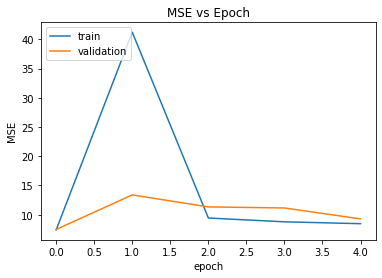

In [ ]:

plt.plot(training.history['loss'])
plt.plot(training.history['val_loss'])
plt.title('MSE vs Epoch')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
training = model.fit(data, labels, batch_size=1, epochs=5, validation_split=.2)

Epoch 1/5
237/237 [==============================] - 13s 47ms/step - loss: 3.1986 - accuracy: 0.1688 - val_loss: 3.2623 - val_accuracy: 0.1833
Epoch 2/5
237/237 [==============================] - 9s 39ms/step - loss: 1.0772 - accuracy: 0.7131 - val_loss: 4.1586 - val_accuracy: 0.1833
Epoch 3/5
237/237 [==============================] - 8s 32ms/step - loss: 0.7142 - accuracy: 0.8143 - val_loss: 4.1552 - val_accuracy: 0.2000
Epoch 4/5
237/237 [==============================] - 7s 32ms/step - loss: 0.4404 - accuracy: 0.8734 - val_loss: 5.0173 - val_accuracy: 0.1667
Epoch 5/5
237/237 [==============================] - 8s 32ms/step - loss: 0.4358 - accuracy: 0.9030 - val_loss: 6.1782 - val_accuracy: 0.1000


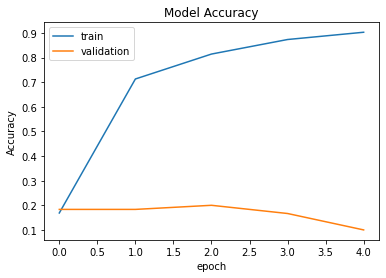

In [ ]:
plt.plot(training.history['accuracy'])
plt.plot(training.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
pred_probs = model.predict(data)
pred_class = np.argmax(pred_probs, axis=1)
pred_class+1

array([ 6,  8,  3,  9, 10,  5,  6,  1,  1,  6,  7,  4,  5,  5,  5,  6,  7,
        7,  5,  4,  7,  5,  3,  3,  5,  5,  7,  3,  5,  4,  7,  4,  6,  6,
        4,  3,  4,  5,  4,  6,  7,  4,  4,  4,  2,  5,  7,  5,  7,  3,  7,
        8,  4,  7,  1,  1,  2,  4,  5,  1,  8,  7,  5,  6,  5,  4,  2,  7,
        2,  3,  7,  6,  9,  5,  9,  8,  6,  7,  5,  5,  1,  4,  4,  3,  5,
        3,  6,  9,  5,  7,  7,  8,  3,  5,  1,  8, 10,  7,  6,  2,  5,  4,
        6,  6,  3,  3,  5,  7,  7,  4,  6,  8,  6,  3,  1,  4,  3,  4,  3,
        4,  5,  6,  2,  6,  8,  7,  5,  1,  6,  4,  2,  4,  2,  2,  5,  6,
        6,  3,  7,  5,  6,  2,  7,  6,  1,  6,  9,  5,  5,  4,  2,  3,  4,
        3,  4,  5,  5,  2,  6,  6,  5,  7,  1,  1,  2,  1,  9,  8,  2,  3,
        2,  5,  5,  3,  7,  1,  6,  7,  4,  6,  5,  2,  6,  4,  7,  2,  9,
        8,  5,  7,  2,  5,  6,  4,  9,  6,  4,  3,  7,  5,  6,  5,  3,  5,
        4,  2,  4,  5,  7,  4,  4,  6,  6,  6,  7,  4,  6,  8,  7,  7,  9,
        3,  6,  5,  7,  6

## Word Embeddings - Clustering


In [ ]:
#Function to create a vector per document by averaging its word vectors.
def vectorize(list_of_docs, model):

    features = []

    for tokens in list_of_docs:
        zero_vector = np.zeros(model.vector_size)
        vectors = []
        for token in tokens:
            if token in model.wv:
                try:
                    vectors.append(model.wv[token])
                except:
                    continue
        if vectors:
            vectors = np.asarray(vectors)
            avg_vec = vectors.mean(axis=0)
            features.append(avg_vec)
        else:
            features.append(zero_vector)
    return features
    

In [ ]:
# vectorized_docs = vectorize(customer_sentences, model_customer)
# len(vectorized_docs), len(vectorized_docs[0])

(100000, 100)

In [ ]:
#Whole sentence
vectorized_docs = vectorize(combined_sentences, model_combined)
len(vectorized_docs), len(vectorized_docs[0])

(100000, 300)

In [ ]:
# #Manual Training List
# vectorized_docs = vectorize(training_sentences, model_combined)
# len(vectorized_docs), len(vectorized_docs[0])


(297, 100)

In [ ]:
def mbkmeans_clusters(X, k, mb, print_silhouette_values, ):
    
    km = MiniBatchKMeans(n_clusters=k, batch_size=mb).fit(X)
    print(f"For n_clusters = {k}")
    print(f"Silhouette coefficient: {silhouette_score(X, km.labels_):0.2f}")
    ##https://scikit-learn.org/stable/modules/clustering.html#silhouette-coefficient
    ##Generally you want silhouette score to be as close to 1 as possible
    if print_silhouette_values:
        sample_silhouette_values = silhouette_samples(X, km.labels_)
        print(f"Silhouette values:")
        silhouette_values = []
        for i in range(k):
            cluster_silhouette_values = sample_silhouette_values[km.labels_ == i]
            silhouette_values.append(
                (
                    i,
                    cluster_silhouette_values.shape[0],
                    cluster_silhouette_values.mean(),
                    cluster_silhouette_values.min(),
                    cluster_silhouette_values.max(),
                )
            )
        silhouette_values = sorted(
            silhouette_values, key=lambda tup: tup[2], reverse=True
        )
        for s in silhouette_values:
            print(
                f"    Cluster {s[0]}: Size:{s[1]} | Avg:{s[2]:.2f} | Min:{s[3]:.2f} | Max: {s[4]:.2f}"
            )
    return km, km.labels_

### Doc2Vec results

In [ ]:
#DOC2VEC giving worse results
clustering, cluster_labels = mbkmeans_clusters( X=model_doc_combined.docvecs.doctag_syn0
, k=10, mb=10000, print_silhouette_values=True)
df_clusters = pd.DataFrame({
      "text": ctq_sample['Chat_parsed'],
      "Customer tokens": [" ".join(text) for text in combined_sentences],
      "cluster": cluster_labels
})

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `doctag_syn0` (Attribute will be removed in 4.0.0, use docvecs.vectors_docs instead).
  """Entry point for launching an IPython kernel.


For n_clusters = 10
Silhouette coefficient: 0.02
Silhouette values:
    Cluster 4: Size:17691 | Avg:0.09 | Min:0.01 | Max: 0.20
    Cluster 3: Size:14235 | Avg:0.04 | Min:-0.03 | Max: 0.14
    Cluster 2: Size:13677 | Avg:0.02 | Min:-0.07 | Max: 0.14
    Cluster 5: Size:6270 | Avg:0.01 | Min:-0.12 | Max: 0.16
    Cluster 9: Size:5993 | Avg:0.01 | Min:-0.12 | Max: 0.16
    Cluster 7: Size:13035 | Avg:0.01 | Min:-0.09 | Max: 0.12
    Cluster 6: Size:7358 | Avg:-0.00 | Min:-0.14 | Max: 0.13
    Cluster 1: Size:6470 | Avg:-0.01 | Min:-0.14 | Max: 0.12
    Cluster 0: Size:8350 | Avg:-0.06 | Min:-0.17 | Max: 0.07
    Cluster 8: Size:6921 | Avg:-0.07 | Min:-0.17 | Max: 0.06


### Word2Vec results

In [ ]:
clustering, cluster_labels = mbkmeans_clusters( X=vectorized_docs, k=10, mb=10000, print_silhouette_values=True)
df_clusters = pd.DataFrame({
      "text": ctq_sample['Chat_parsed'],
      "Customer tokens": [" ".join(text) for text in combined_sentences],
      "cluster": cluster_labels
})

For n_clusters = 10
Silhouette coefficient: 0.08
Silhouette values:
    Cluster 9: Size:1993 | Avg:0.16 | Min:-0.11 | Max: 0.39
    Cluster 5: Size:7526 | Avg:0.14 | Min:-0.00 | Max: 0.31
    Cluster 6: Size:17512 | Avg:0.11 | Min:-0.03 | Max: 0.26
    Cluster 7: Size:10205 | Avg:0.10 | Min:-0.02 | Max: 0.27
    Cluster 3: Size:15901 | Avg:0.09 | Min:-0.01 | Max: 0.23
    Cluster 4: Size:5214 | Avg:0.07 | Min:-0.07 | Max: 0.25
    Cluster 1: Size:12648 | Avg:0.06 | Min:-0.07 | Max: 0.22
    Cluster 2: Size:9272 | Avg:0.05 | Min:-0.04 | Max: 0.20
    Cluster 8: Size:13542 | Avg:0.03 | Min:-0.06 | Max: 0.13
    Cluster 0: Size:6187 | Avg:0.00 | Min:-0.15 | Max: 0.20


In [ ]:
for i in range(10):
    tokens_per_cluster = ""
    most_representative = model_combined.wv.most_similar(positive=[clustering.cluster_centers_[i]], topn=10)
    for t in most_representative:
        tokens_per_cluster += f"{t[0]} "
    print(f"Cluster {i}: {tokens_per_cluster}")

Cluster 0: aservicetagg plz dsp aservicetagb sir aservicetagw aservicetagi aservicetagm aservicetagh drt 
Cluster 1: warranty purchase purchasing warrenty reseller therefore discount order buy pay 
Cluster 2: part ost cx mobo insists declined denies refused insisted replace 
Cluster 3: bios driver window installs o rebooted utility reboot try generic 
Cluster 4: ty nah sweet kk partselection pn coolio improve yw man 
Cluster 5: system zone valid active est caused ensure confirming near physical 
Cluster 6: sent addresscontact dispatch tech part technician quote perfect mailed absolutely 
Cluster 7: power plugged unplugged plug adapter light plugging turn powered charger 
Cluster 8: computer system laptop monitor device display detects recognizes pc dock 
Cluster 9: response reply chatthank received minute disconnect conversation reponse connected kindly 


In [ ]:
ctq_sample['Cluster'] = cluster_labels

In [ ]:
ctq_sample.to_csv("Analysis.csv")